In [1]:
from keras.datasets import mnist

(trainX, trainY), (testX, testY) = mnist.load_data()

Using TensorFlow backend.


In [2]:
from keras.models import Model
from keras.layers import Input, Reshape, Dense, Flatten, Dropout, LeakyReLU

class Autoencoder:
  def __init__(self, img_shape=(28, 28), latent_dim=2, n_layers=2, n_units=128):
    # encoder
    h = i = Input(img_shape)
    h = Flatten()(h)
    for _ in range(n_layers):
      h = Dense(n_units, activation='relu')(h)
    o = Dense(latent_dim)(h)
    self.encoder = Model(inputs=[i], outputs=[o])

    # decoder
    i = h = Input((latent_dim,))
    for _ in range(n_layers):
      h = Dense(n_units, activation='relu')(h)
    h = Dense(img_shape[0] * img_shape[1])(h)
    o = Reshape(img_shape)(h) # predict 1 frame
    self.decoder = Model(inputs=[i], outputs=[o])

    # stacked autoencoder
    i = Input(img_shape)
    z = self.encoder(i) # push observations into latent space
    o = self.decoder(z) # project from latent space to feature space
    self.auto = Model(inputs=[i], outputs=[o])
    self.auto.compile(loss='mse', optimizer='adam')
  
model = Autoencoder()

In [3]:
model.auto.fit(trainX, trainX, validation_data=(testX[:100], testX[:100]), batch_size=100, epochs=10)

Train on 60000 samples, validate on 100 samples
Epoch 1/10
60000/60000 [==============================] - 2s 40us/step - loss: 3546.0533 - val_loss: 2979.3123
Epoch 2/10
60000/60000 [==============================] - 2s 37us/step - loss: 3112.0743 - val_loss: 2814.6201
Epoch 3/10
60000/60000 [==============================] - 2s 40us/step - loss: 2993.4200 - val_loss: 2773.1406
Epoch 4/10
60000/60000 [==============================] - 2s 41us/step - loss: 2925.9216 - val_loss: 2761.0732
Epoch 5/10
60000/60000 [==============================] - 2s 40us/step - loss: 2889.5226 - val_loss: 2711.3540
Epoch 6/10
60000/60000 [==============================] - 2s 38us/step - loss: 2852.2920 - val_loss: 2670.7441
Epoch 7/10
60000/60000 [==============================] - 3s 44us/step - loss: 2821.1478 - val_loss: 2708.4866
Epoch 8/10
60000/60000 [==============================] - 3s 47us/step - loss: 2786.0166 - val_loss: 2659.7593
Epoch 9/10
60000/60000 [==============================] - 3s 42u

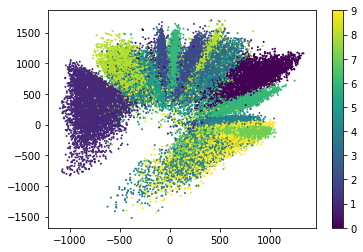

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline

# transform each input image into the latent space
z = model.encoder.predict(trainX)

# color each point by its label
colors = trainY.tolist()

# plot the latent space
plt.scatter(z[:,0], z[:,1], marker='o', s=1, c=colors)
plt.colorbar()

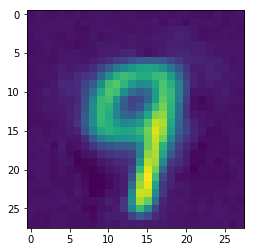

In [5]:
import numpy as np

# sample from the region -50, -50
y = np.array([[60, -30]])
prediction = model.decoder.predict(y)
plt.imshow(prediction.squeeze())

# Create JS data structures

In [6]:
import json

with open('data/trainX-sample.json', 'w') as out:
  json.dump(trainX[:50].tolist(), out)
  
with open('data/trainY.json', 'w') as out:
  json.dump(trainY.tolist(), out)

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import math

px_per_cell_side = 28
cells_per_axis = math.floor(2048/px_per_cell_side)
cells_per_atlas = cells_per_axis**2
n_atlases = math.ceil(trainX.shape[0] / cells_per_atlas)

# create a series of columns and suture them together
for i in range(n_atlases-1): # -1 to just create full atlas files (skip the remainder)
  start = i * cells_per_atlas
  end = (i+1) * cells_per_atlas
  x = trainX[start:end]
  cols = []
  for j in range(cells_per_axis):
    col_start = j*cells_per_axis
    col_end = (j+1)*cells_per_axis
    col = x[col_start:col_end].reshape(px_per_cell_side*cells_per_axis, px_per_cell_side)
    cols.append(col)
  im = np.hstack(cols)
  im = 255-im # use 255- to flip black and white
  plt.imsave('images/atlas-images/atlas-' + str(i) + '.jpg', im, cmap='gray')
  # get a single row of images to render to ui
  row = 255-x[col_start:col_end]
  if False: plt.imsave('images/sample-row.jpg', np.hstack(row), cmap='gray')
print(' * total cells:', n_atlases * cells_per_atlas)

 * total cells: 63948


In [8]:
consumed = set()
for i in range(10):
  for jdx, j in enumerate(trainY):
    if j == i:
      im = 255 - trainX[jdx].squeeze()
      plt.imsave('images/digits/digit-' + str(i) + '.png', im, cmap='gray')
      break

In [9]:
# create low dimensional embeddings
# from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.manifold import TSNE, MDS, SpectralEmbedding, Isomap, LocallyLinearEmbedding
from umap import UMAP
from copy import deepcopy
import rasterfairy
import json

def center(arr):
  '''Center an array to clip space -0.5:0.5 on all axes'''
  arr = deepcopy(arr)
  for i in range(arr.shape[1]):
    arr[:,i] = arr[:,i] - np.min(arr[:,i])
    arr[:,i] = arr[:,i] / np.max(arr[:,i])
    arr[:,i] -= 0.5
  return arr

def curate(arr):
  '''Prepare an array for persistence to json'''
  return np.around(center(arr), 4).tolist()

# prepare model inputs
n = 10000 #trainX.shape[0]
sampleX = trainX[:n]
flat = sampleX.reshape(sampleX.shape[0], sampleX.shape[1] * sampleX.shape[2])

In [10]:
# create sklearn outputs
for clf, label in [
  #[SpectralEmbedding, 'se'],
  #[Isomap, 'iso'],
  #[LocallyLinearEmbedding, 'lle'],
  #[MDS, 'mds'],
  [TSNE, 'tsne'],
  [UMAP, 'umap'],
]:
  print(' * processing', label)
  positions = clf(n_components=2).fit_transform(flat)
  with open('data/mnist-positions/' + label + '_positions.json', 'w') as out:
    json.dump(curate(positions), out)

 * processing tsne
 * processing umap


In [37]:
import keras.backend as K
import numpy as np
import os, json

# create autoencoder outputs
model = Autoencoder(latent_dim=2)
lr = 0.005
for i in range(10):
  lr *= 0.9
  print(' * running step:', i, '-- lr:', lr)
  K.set_value(model.auto.optimizer.lr, lr)
  model.auto.fit(trainX, trainX, batch_size=250, epochs=10)  

# save the auto latent positions to disk
auto_positions = model.encoder.predict(sampleX)
with open('data/mnist-positions/auto_positions.json', 'w') as out:
  json.dump(curate(auto_positions), out)
  
# save the decoder to disk
model.decoder.save('data/model/decoder.h5')
os.system('tensorflowjs_converter --input_format keras \
                       data/model/decoder.h5 \
                       data/model/decoder')

# save the decoder domain to disk
domains = [[ float(np.min(z[:,i])), float(np.max(z[:,i])) ] for i in range(z.shape[1])]
with open('data/model/decoder-domains.json', 'w') as out:
  json.dump(domains, out)

 * running step: 0 -- lr: 0.0045000000000000005
Epoch 1/10
60000/60000 [==============================] - 2s 30us/step - loss: 3806.8736
Epoch 2/10
60000/60000 [==============================] - 1s 21us/step - loss: 3208.7831
Epoch 3/10
60000/60000 [==============================] - 1s 22us/step - loss: 3010.6799
Epoch 4/10
60000/60000 [==============================] - 1s 23us/step - loss: 2915.7436
Epoch 5/10
60000/60000 [==============================] - 1s 22us/step - loss: 2858.5742
Epoch 6/10
60000/60000 [==============================] - 1s 22us/step - loss: 2822.1897
Epoch 7/10
60000/60000 [==============================] - 1s 23us/step - loss: 2796.3649
Epoch 8/10
60000/60000 [==============================] - 1s 24us/step - loss: 2766.2763
Epoch 9/10
60000/60000 [==============================] - 1s 24us/step - loss: 2758.2997
Epoch 10/10
60000/60000 [==============================] - 1s 24us/step - loss: 2758.4309
 * running step: 1 -- lr: 0.004050000000000001
Epoch 1/10
600

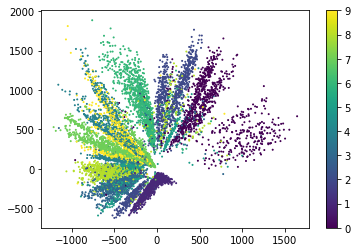

In [38]:
%matplotlib inline

import matplotlib.pyplot as plt

# plot the latent space
z = model.encoder.predict(trainX[:n]) # project inputs into latent space
colors = trainY[:n].tolist() # color points with labels
plt.scatter(z[:,0], z[:,1], marker='o', s=1, c=colors)
plt.colorbar()

In [13]:
import math

px_per_cell_side = 28
cells_per_axis = math.floor(2048/px_per_cell_side)
cells_per_atlas = cells_per_axis**2
n_atlases = math.ceil(trainX.shape[0] / cells_per_atlas)
print(' * total cells:', n_atlases * cells_per_atlas)

# create a series of columns and suture them together
for i in range(n_atlases-1): # -1 to just create full atlas files (skip the remainder)
  start = i * cells_per_atlas
  end = (i+1) * cells_per_atlas
  x = trainX[start:end]
  cols = []
  for j in range(cells_per_axis):
    col_start = j*cells_per_axis
    col_end = (j+1)*cells_per_axis
    col = x[col_start:col_end].reshape(px_per_cell_side*cells_per_axis, px_per_cell_side)
    cols.append(col)
  im = np.hstack(cols)
  plt.imsave('atlas-' + str(i) + '.jpg', im, cmap='gray')

 * total cells: 63948


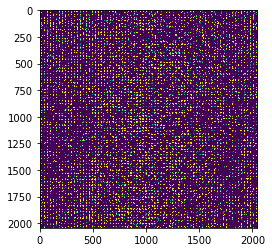

In [14]:
b = np.hstack(cols)
plt.imshow(b)